<a href="https://colab.research.google.com/github/okorch/project_AI_cancer/blob/main/Cancer_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pickle
import torch
import torchvision
from torchvision import transforms
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F  # Functional
import numpy as np
import matplotlib.pyplot as plt  # для отрисовки картиночек
from tqdm.notebook import trange, tqdm
%matplotlib inline

# Проверяем, доступны ли GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
device

'cpu'

In [3]:
with open('/content/drive/MyDrive/X_train_new.pickle', 'rb') as f:
  X, y = pickle.load(f)

In [4]:
for i in range(len(y)):
  y[i] = int(y[i])
np.unique(np.array(y), return_counts= True)

(array([0, 1]), array([6007, 3993]))

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
len(X_train)

8000

In [8]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import seaborn as sns
from torch.utils.data import TensorDataset

In [9]:
train_dataset = list(zip(X_train, y_train))
trainloader = DataLoader(train_dataset, 4, shuffle = True)


In [46]:
# простая сверточная нейронка
class SimpleConvNet(nn.Module):
    def __init__(self):
        super(SimpleConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=64, kernel_size=5)
        self.fc1 = nn.Linear(4 * 2704, 2048)  # !!!
        self.drop1 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(2048, 512)
        self.drop2 = nn.Dropout(p=0.15)
        self.fc3 = nn.Linear(512, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 4 * 2704)
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = F.relu(self.fc2(x))
        x = self.drop2(x)
        x = self.fc3(x)
        return torch.sigmoid(x)

In [47]:
# объявляем сеть
net = SimpleConvNet().to(device)

In [48]:
# выбираем функцию потерь
loss_fn = torch.nn.functional.binary_cross_entropy


# выбираем алгоритм оптимизации и learning_rate
learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
losses = []

In [38]:
cuda0 = torch.device('cuda:0')

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

[1,   200] loss: 0.656
[1,   400] loss: 0.621
[1,   600] loss: 0.592
[1,   800] loss: 0.484
[1,  1000] loss: 0.537
[1,  1200] loss: 0.489
[1,  1400] loss: 0.493
[1,  1600] loss: 0.498
[1,  1800] loss: 0.518
[1,  2000] loss: 0.483


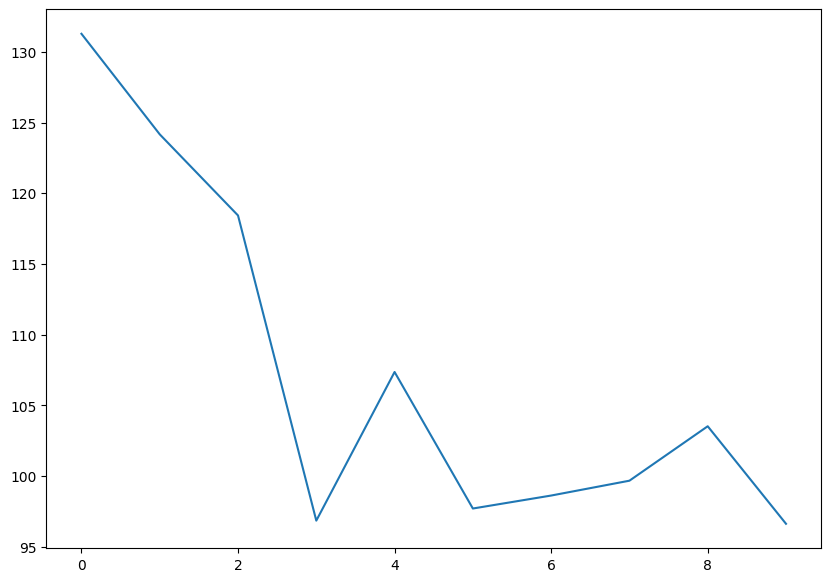

  0%|          | 0/2000 [00:00<?, ?it/s]

[2,   200] loss: 0.476
[2,   400] loss: 0.479
[2,   600] loss: 0.474
[2,   800] loss: 0.482
[2,  1000] loss: 0.523
[2,  1200] loss: 0.511
[2,  1400] loss: 0.486
[2,  1600] loss: 0.473
[2,  1800] loss: 0.469
[2,  2000] loss: 0.467


  0%|          | 0/2000 [00:00<?, ?it/s]

[3,   200] loss: 0.453
[3,   400] loss: 0.481
[3,   600] loss: 0.472
[3,   800] loss: 0.487
[3,  1000] loss: 0.457
[3,  1200] loss: 0.473
[3,  1400] loss: 0.466
[3,  1600] loss: 0.487
[3,  1800] loss: 0.474
[3,  2000] loss: 0.471


  0%|          | 0/2000 [00:00<?, ?it/s]

[4,   200] loss: 0.467
[4,   400] loss: 0.427
[4,   600] loss: 0.440
[4,   800] loss: 0.485
[4,  1000] loss: 0.463
[4,  1200] loss: 0.440
[4,  1400] loss: 0.445
[4,  1600] loss: 0.475
[4,  1800] loss: 0.449
[4,  2000] loss: 0.427
Обучение закончено


In [49]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1)

# итерируемся
for epoch in tqdm(range(4)):

    running_loss = 0.0
    for i, batch in enumerate(tqdm(trainloader)):
        # так получаем текущий батч
        X_batch, y_batch = batch
        
        # обнуляем веса
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred = net(X_batch.type(torch.FloatTensor))
        y_batch = torch.reshape(y_batch.type(torch.FloatTensor), (len(y_batch), 1))
        loss = loss_fn(y_pred, y_batch)

        loss.backward()
        optimizer.step()

        # выведем текущий loss
        running_loss += loss.item()
        # выведем качество каждые 200 батчей
        if i % 200 == 199:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            losses.append(running_loss)
            running_loss = 0.0

    ax.clear()
    ax.plot(np.arange(len(losses)), losses)
    plt.show()

print('Обучение закончено')

In [50]:
test_dataset = list(zip(X_test, y_test))
testloader = DataLoader(test_dataset, 4, shuffle = True)

In [51]:
from sklearn import metrics

In [52]:
y_test = []
pred = []
for data in testloader:
  X, y = data
  y_pred = net(X.to(device))
  for i in range(4):
    pred.append(int(torch.round(y_pred[i])))
    y_test.append(int(y[i]))
print(y_test)
print(pred)
print(metrics.accuracy_score(y_test, pred))
print(metrics.f1_score(y_test, pred))

[0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 